### Import required packages

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import Row
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.classification import NaiveBayes
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from time import time
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
conf = SparkConf().setMaster("local").setAppName("Project_BigData")
sc = SparkContext.getOrCreate(conf = conf)
sqlcon = SQLContext.getOrCreate(sc)

In [3]:
pat1 = re.compile(r'"([a-xA-Z0-9. ,]+), ([a-xA-Z0-9. ,]+)"')
pat2 = re.compile(r'"([,]+)"')
keep = ['CASE_STATUS','EMPLOYER_NAME','EMPLOYER_STATE',\
        'AGENT_REPRESENTING_EMPLOYER','JOB_TITLE','SOC_NAME','NAICS_CODE','TOTAL_WORKERS',\
        'NEW_EMPLOYMENT','CONTINUED_EMPLOYMENT','CHANGE_PREVIOUS_EMPLOYMENT',\
        'NEW_CONCURRENT_EMPLOYMENT','CHANGE_EMPLOYER','AMENDED_PETITION','FULL_TIME_POSITION',\
        'PREVAILING_WAGE','H1B_DEPENDENT','SUPPORT_H1B','WORKSITE_STATE','CASE_SUBMITTED']
#We need to decide how to use the date 'CASE_SUBMITTED', add back to the list above once decided.
categorical = {"CASE_STATUS":"CASE_STATUS_C", "EMPLOYER_NAME":"EMPLOYER_NAME_C",\
              "EMPLOYER_STATE":"EMPLOYER_STATE_C","AGENT_REPRESENTING_EMPLOYER":"AGENT_REPRESENTING_EMPLOYER_C",\
              "JOB_TITLE":"JOB_TITLE_C","SOC_NAME":"SOC_NAME_C","NAICS_CODE":"NAICS_CODE_C",\
              "FULL_TIME_POSITION":"FULL_TIME_POSITION_C","H1B_DEPENDENT":"H1B_DEPENDENT_C",\
              "WORKSITE_STATE":"WORKSITE_STATE_C","SUPPORT_H1B":"SUPPORT_H1B_C"}
target = ["CASE_STATUS_C","CASE_SUBMITTED"]

## Data Preparation
### Involves several methods to cleanup data -

1. Remove commas within quotes strings
2. Convert wage to yearly wage
3. Create Rows for the dataframe
4. Convert categorical variables to codes

In [4]:
def replaceCommaWithinQuotes(line):
    '''
    Remove commas within quotes with some words, recursion makes sure we reomve all such commas
    '''
    if len(pat1.findall(line)) == 0:
        return line
    line = pat1.sub( r'"\1 \2"', line )
    return replaceCommaWithinQuotes(line)

In [5]:
def yearlyWage(data_dict):
    '''
    Converts the prevailing wage to yearly.
    '''
    sal = 0.0
    try:
        sal = float(data_dict['PREVAILING_WAGE'])
    except:
        sal = 0.0
        #do nothing
    if data_dict['PW_UNIT_OF_PAY'] == 'Hour':
        sal = sal*40*52 #40 hrs/week,52 weeks/yr
    if data_dict['PW_UNIT_OF_PAY'] == 'Week':
        sal = sal*52    #52 weeks/yr
    if data_dict['PW_UNIT_OF_PAY'] == 'Bi-Weekly':
        sal = sal*26    #52 weeks/yr,hence 26 bi-weeks 
    if data_dict['PW_UNIT_OF_PAY'] == 'Month':
        sal = sal*12    #12 months/yr
    if data_dict['PW_UNIT_OF_PAY'] == 'Year':
        sal == sal
    data_dict['PREVAILING_WAGE'] = sal
    return data_dict

In [6]:
def createRow(line, headers):
    '''
    Returns a dictionary with headers as key and their values as the values
    '''
    data_dict = {}
    #Replace comma, within words between two quotes, with blank
    line = replaceCommaWithinQuotes(line) #This line may still have just comma within quotes-","
    #line = pat2.sub(r'""', line) - something weird is happening because of this line

    data_list = line.split(",")
    j = 0 #another index
    for i in range(len(headers)):
        if data_list[j] == '"': #In case we encounter a " we avoid it and move ahead.
            j = j+1
        if headers[i] == "":
            data_dict["S_NO"] = int(data_list[j])
        else:
            data_dict[headers[i]] = data_list[j]
        j = j+1
    #We make the prevailing wage yearly
    data_dict = yearlyWage(data_dict)
    date_submitted = data_dict["CASE_SUBMITTED"]
    data_dict["CASE_SUBMITTED"] = date_submitted[-4:]
    return data_dict

In [7]:
def convertToCategorical(columns, dataframe):
    '''
    Converts each column in dataframe to its corresponding Cateforical column.
    columns is a dict representing the column as key and new colmn as value.
    '''
    for column in columns:
        indexer = StringIndexer(inputCol=column, outputCol=columns[column])
        dataframe = indexer.fit(dataframe).transform(dataframe)
    return dataframe

In [8]:
def createLabeledPoints(line):
    '''
    Converts each value to a float and returns as LabeledPoint.
    If conversion fails then null is returned.
    '''
    values = []
    for x in line:
        try:
            values.append(float(x))
        except:
            return None
    return LabeledPoint(values[0], values[1:])

In [9]:
h1b_data = sc.textFile(\
           "D:\\PBDA\\Project\\Data\\H-1B_Disclosure_Data_FY17.csv")

In [10]:
headers_string = h1b_data.take(1)[0]
headers = headers_string.split(",")
h1b_data = h1b_data.filter(lambda x: x != headers_string)

In [11]:
h1_data_map = h1b_data.map(lambda x: Row(**createRow(x, headers)))
h1b_data_frame = sqlcon.createDataFrame(h1_data_map).cache()
h1b_data_frame

DataFrame[AGENT_ATTORNEY_CITY: string, AGENT_ATTORNEY_NAME: string, AGENT_ATTORNEY_STATE: string, AGENT_REPRESENTING_EMPLOYER: string, AMENDED_PETITION: string, CASE_NUMBER: string, CASE_STATUS: string, CASE_SUBMITTED: string, CHANGE_EMPLOYER: string, CHANGE_PREVIOUS_EMPLOYMENT: string, CONTINUED_EMPLOYMENT: string, DECISION_DATE: string, EMPLOYER_ADDRESS: string, EMPLOYER_BUSINESS_DBA: string, EMPLOYER_CITY: string, EMPLOYER_COUNTRY: string, EMPLOYER_NAME: string, EMPLOYER_PHONE: string, EMPLOYER_PHONE_EXT: string, EMPLOYER_POSTAL_CODE: string, EMPLOYER_PROVINCE: string, EMPLOYER_STATE: string, EMPLOYMENT_END_DATE: string, EMPLOYMENT_START_DATE: string, FULL_TIME_POSITION: string, H1B_DEPENDENT: string, JOB_TITLE: string, LABOR_CON_AGREE: string, NAICS_CODE: string, NEW_CONCURRENT_EMPLOYMENT: string, NEW_EMPLOYMENT: string, ORIGINAL_CERT_DATE: string, PREVAILING_WAGE: double, PUBLIC_DISCLOSURE_LOCATION: string, PW_SOURCE: string, PW_SOURCE_OTHER: string, PW_SOURCE_YEAR: string, PW_UNI

In [12]:
h1b_data_frame = h1b_data_frame.where(h1b_data_frame['VISA_CLASS'] == 'H-1B')
h1b_data_frame.take(2)

[Row(AGENT_ATTORNEY_CITY='NEW YORK', AGENT_ATTORNEY_NAME='"ELLSWORTH CHAD"', AGENT_ATTORNEY_STATE='NY', AGENT_REPRESENTING_EMPLOYER='Y', AMENDED_PETITION='0', CASE_NUMBER='I-200-16055-173457', CASE_STATUS='CERTIFIED-WITHDRAWN', CASE_SUBMITTED='2016', CHANGE_EMPLOYER='0', CHANGE_PREVIOUS_EMPLOYMENT='0', CONTINUED_EMPLOYMENT='0', DECISION_DATE='01/10/2016', EMPLOYER_ADDRESS='2500 LAKE COOK ROAD', EMPLOYER_BUSINESS_DBA='N/A', EMPLOYER_CITY='RIVERWOODS', EMPLOYER_COUNTRY='UNITED STATES OF AMERICA', EMPLOYER_NAME='DISCOVER PRODUCTS INC.', EMPLOYER_PHONE='2244050900', EMPLOYER_PHONE_EXT='', EMPLOYER_POSTAL_CODE='60015', EMPLOYER_PROVINCE='N/A', EMPLOYER_STATE='IL', EMPLOYMENT_END_DATE='10/08/2019', EMPLOYMENT_START_DATE='10/08/2016', FULL_TIME_POSITION='Y', H1B_DEPENDENT='"67', JOB_TITLE='ASSOCIATE DATA INTEGRATION', LABOR_CON_AGREE='N', NAICS_CODE='522210', NEW_CONCURRENT_EMPLOYMENT='0', NEW_EMPLOYMENT='1', ORIGINAL_CERT_DATE='LAKE', PREVAILING_WAGE=0.0, PUBLIC_DISCLOSURE_LOCATION='N', PW_S

In [13]:
h1b_data_frame_0 = h1b_data_frame.where(h1b_data_frame['AGENT_ATTORNEY_CITY'] == 'MINNEAPOLIS' )
h1b_data_frame_0.toPandas()

,AGENT_ATTORNEY_CITY,AGENT_ATTORNEY_NAME,AGENT_ATTORNEY_STATE,AGENT_REPRESENTING_EMPLOYER,AMENDED_PETITION,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,CHANGE_EMPLOYER,CHANGE_PREVIOUS_EMPLOYMENT,...,TOTAL_WORKERS,VISA_CLASS,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO,WAGE_UNIT_OF_PAY,WILLFUL_VIOLATOR,WORKSITE_CITY,WORKSITE_COUNTY,WORKSITE_POSTAL_CODE,WORKSITE_STATE
0,MINNEAPOLIS,"""YOST PETER""",MN,Y,0,I-200-16270-978090,CERTIFIED,2016,0,0,...,1,H-1B,WILLIS TOWERS WATSON:PROFESSIONAL (TECHNICAL &...,"""95","400.00""","638.00""",NA,,PELLA,
1,MINNEAPOLIS,"""RAJAN ANITHA""",MN,Y,0,I-200-16267-263193,CERTIFIED,2016,0,0,...,1,H-1B,OFLC ONLINE DATA CENTER,"""70","000.00""",Year,,,DAKOTA,EAGAN
2,MINNEAPOLIS,"""RAJAN ANITHA""",MN,Y,0,I-200-16272-589451,DENIED,2016,1,0,...,1,H-1B,OFLC ONLINE DATA CENTER,"""90","000.00""",Year,,,WASHINGTON,WOODBURY
3,MINNEAPOLIS,"""SCHNEIDER DEBRA""",MN,Y,0,I-200-15070-893773,CERTIFIED-WITHDRAWN,2016,0,0,...,1,H-1B,OFLC ONLINE DATA CENTER,"""56","000.00""",Year,,,NEW YORK,NEW YORK
4,MINNEAPOLIS,"""KILIBARDA SARAH""",MN,Y,0,I-200-16238-825863,CERTIFIED,2016,0,0,...,1,H-1B,OFLC ONLINE DATA CENTER,"""113","256.00""","600.00""",NA,Y,BASKING RIDGE,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,MINNEAPOLIS,"""SCHNEIDER DEBRA""",MN,Y,0,I-200-16292-134762,CERTIFIED-WITHDRAWN,2016,0,1,...,1,H-1B,OFLC ONLINE DATA CENTER,"""101","353.00""",Year,,,MIDDLESEX,BILLERICA
2148,MINNEAPOLIS,"""MEDEIROS JOHN""",MN,Y,0,I-200-17026-165039,CERTIFIED-WITHDRAWN,2017,0,0,...,1,H-1B,OFLC ONLINE DATA CENTER,"""225","000.00""",Year,,,CLEARWATER,BAGLEY
2149,MINNEAPOLIS,"""MEDEIROS JOHN""",MN,Y,0,I-200-17058-458206,CERTIFIED-WITHDRAWN,2017,0,0,...,1,H-1B,OFLC ONLINE DATA CENTER,"""225","000.00""",Year,,,CLEARWATER COUNTY,BAGLEY
2150,MINNEAPOLIS,"""WELLS ALLISON""",MN,Y,0,I-200-17044-101912,CERTIFIED-WITHDRAWN,2017,0,0,...,1,H-1B,OFLC ONLINE DATA CENTER,"""60","000.00""",Year,,,MARATHON,SCHOFIELD


In [57]:
h1b_data_frame_reduced, dummy = h1b_data_frame.randomSplit([0.1, 0.9])

In [58]:
h1b_data_frame_1 = convertToCategorical(categorical, h1b_data_frame_reduced)

In [59]:
keeps = [x for x in keep if x not in categorical.keys() ] + list(categorical.values())
keeps = list(target) + [x for x in keeps if x not in target]
h1b_data_frame_2 = h1b_data_frame_1[keeps].cache()

In [60]:
h1b_labeled_points = h1b_data_frame_2.rdd.map(createLabeledPoints)
h1b_labeled_points = h1b_labeled_points.filter(lambda x : x != None)

In [18]:
h1b_labeled_points.take(10)

[LabeledPoint(1.0, [2015.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,460.0,5.0,1.0,0.0,2.0,16.0,0.0,0.0,1166.0,1.0]),
 LabeledPoint(1.0, [2015.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1348.0,0.0,1.0,443.0,79.0,2.0,0.0,0.0,169.0,0.0]),
 LabeledPoint(1.0, [2013.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2485.0,4.0,1.0,485.0,26.0,21.0,0.0,0.0,1160.0,0.0]),
 LabeledPoint(1.0, [2013.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,270.0,7.0,1.0,33.0,26.0,2.0,0.0,0.0,15.0,0.0]),
 LabeledPoint(1.0, [2013.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,1.0,449.0,0.0,19.0,0.0,0.0,13.0,0.0]),
 LabeledPoint(1.0, [2013.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1399.0,9.0,1.0,3.0,0.0,33.0,0.0,0.0,2277.0,1.0]),
 LabeledPoint(2.0, [2013.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,402.0,1.0,1.0,244.0,22.0,2.0,0.0,0.0,9.0,0.0]),
 LabeledPoint(1.0, [2013.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10117.0,0.0,1.0,9306.0,89.0,461.0,0.0,0.0,3.0,0.0]),
 LabeledPoint(1.0, [2013.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5338.0,0.0,1.0,55.0,26.0,58.0,0.0,0.0,225.0,0.0]),
 LabeledPoint(1.0

In [19]:
df=h1b_labeled_points.toDF()
df

DataFrame[features: vector, label: double]

In [20]:
df.toPandas()['label'].unique()

array([1., 2., 3., 0.])

# Vizualization

In [21]:
def barPlot(dataframe, color="Blue"):
    """
    Takes a dataframe with two columns and creates bar plot.
    The first column is the labels and second is the count.
    The dataframe is a pyspark dataframe
    """
    X = []
    Y = []
    for x in dataframe.collect():
        X.append(x[0])
        Y.append(x[1])
    pos = np.arange(len(X))
    
    plt.barh(pos, Y, align='center', color=color)
    plt.yticks(pos, X)

In [22]:
def top_10_companies_by_status(h1b_data_frame, status):
    status_by_company = h1b_data_frame.where(h1b_data_frame['CASE_STATUS'] == status)
    #1. Map by Employer name
    #2. Reduce by count
    #3. Map with count as key, employer as value this makes the sorting easier as you can sortByKey
    status_by_company = status_by_company.rdd.map(lambda x : (x.EMPLOYER_NAME, 1)).\
                    reduceByKey(lambda x,y : x+y).map(lambda x : (x[1],x[0]))
    status_by_company_sorted = status_by_company.sortByKey(ascending=False)
    status_by_company_sorted_10 = status_by_company_sorted.toDF().limit(10)
    status_by_company_sorted_10 = status_by_company_sorted_10.rdd.map(lambda x : (x[1],x[0])).toDF()
    return status_by_company_sorted_10

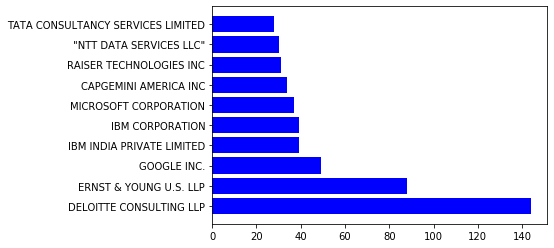

In [23]:
barPlot(top_10_companies_by_status(h1b_data_frame, "DENIED"))
plt.show()

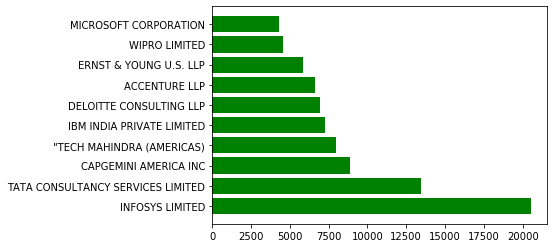

In [24]:
#Top 10 cmpanies with Certified status
barPlot(top_10_companies_by_status(h1b_data_frame, "CERTIFIED"),"Green")
plt.show()

In [25]:
prevailingwage_by_state = h1b_data_frame.rdd.map(lambda x :(x.EMPLOYER_STATE, (x.PREVAILING_WAGE, 1)))\
    .reduceByKey(lambda x, y : (x[0]+y[0], x[1]+y[1]))\
    .mapValues(lambda x : float(x[0])/float(x[1]))\
    .map(lambda x : (x[1],x[0]))
prevailingwage_by_state_sorted = prevailingwage_by_state.sortByKey(ascending=False)
prevailingwage_by_state_sorted_10 = prevailingwage_by_state_sorted.filter(lambda x: x[1]!= "").toDF().limit(10)

In [26]:
prevailingwage_by_state_sorted_10

DataFrame[_1: double, _2: string]

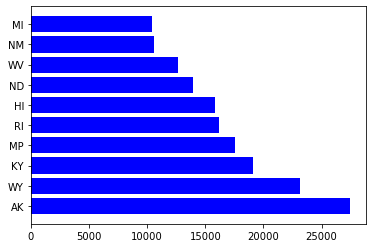

In [27]:
prevailingwage_by_state_sorted_10 = prevailingwage_by_state_sorted_10.rdd.map(lambda x : (x[1],x[0]))
barPlot(prevailingwage_by_state_sorted_10)
plt.show()

In [28]:
# Analysis of why CA is behind GA in avg wage for H-1B workers
CA_applicants = h1b_data_frame.where(h1b_data_frame['EMPLOYER_STATE'] == 'MI')
print('Total number of applicants in Michigan : ' + str(CA_applicants.count()))

GA_applicants=h1b_data_frame.where(h1b_data_frame['EMPLOYER_STATE'] == 'RI')
print('Total number of applicants in RHode Island : ' + str(GA_applicants.count()))

Total number of applicants in Michigan : 26393
Total number of applicants in RHode Island : 1019


In [29]:
def year_wise_status(h1b_data_frame, status):
    status_by_year = h1b_data_frame\
    .rdd.map(lambda x : (x.CASE_SUBMITTED, (1, 1 if x.CASE_STATUS == status else 0)))\
    .reduceByKey(lambda x, y : (x[0]+y[0], x[1]+y[1]))\
    .mapValues(lambda x : float(x[1])*100/float(x[0]))\
    .sortByKey()
    return status_by_year

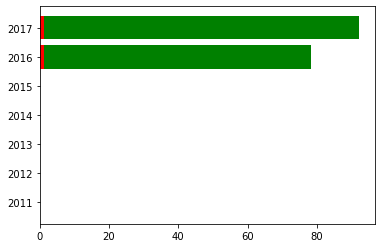

In [30]:
barPlot(year_wise_status(h1b_data_frame, "CERTIFIED"), "Green")
barPlot(year_wise_status(h1b_data_frame, "DENIED"), "Red")
plt.show()

In [31]:
def top_10_soc_by_status(h1b_data_frame, status):
    status_by_soc = h1b_data_frame.where(h1b_data_frame['CASE_STATUS'] == status)
    #1. Map by SOC
    #2. Reduce by count
    #3. Map with count as key, SOC as value this makes the sorting easier as you can sortByKey
    status_by_soc = status_by_soc.rdd.map(lambda x : (x.SOC_NAME, 1)).\
                    reduceByKey(lambda x,y : x+y).map(lambda x : (x[1],x[0]))
    status_by_soc_sorted = status_by_soc.sortByKey(ascending=False)
    status_by_soc_sorted_10 = status_by_soc_sorted.toDF().limit(10)
    status_by_soc_sorted_10 = status_by_soc_sorted_10.rdd.map(lambda x : (x[1],x[0])).toDF()
    return status_by_soc_sorted_10

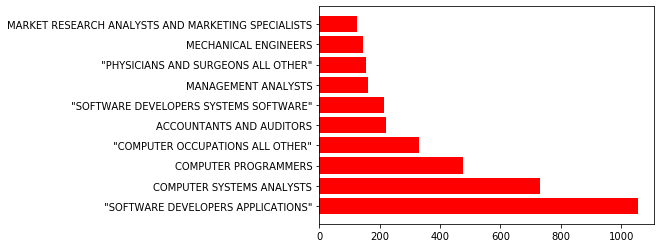

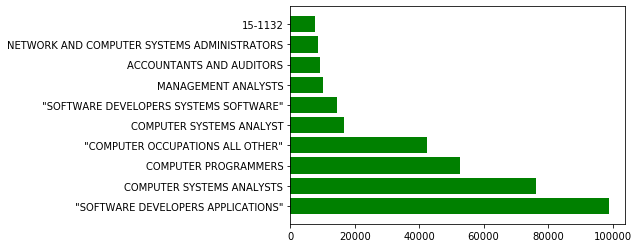

In [32]:
#Top 10 soc with status
barPlot(top_10_soc_by_status(h1b_data_frame, "DENIED"),"RED")
plt.show()

barPlot(top_10_soc_by_status(h1b_data_frame, "CERTIFIED"),"GREEN")
plt.show()

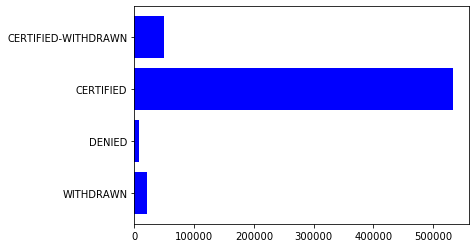

In [33]:
class_count = h1b_data_frame.rdd.map(lambda x : (x.CASE_STATUS, 1)).reduceByKey(lambda x, y : x+y)
barPlot(class_count)
plt.show()

## Data Modelling

In [61]:
#Define a method to evaludate any model
def evaluate_model(test, model):
    '''
    Returns accuracy based on correct predictions
    '''
    predictions = model.predict(test.map(lambda x: x.features))
    predictionAndLabel = test.map(lambda y: y.label).zip(predictions)
    return 100*predictionAndLabel.filter(lambda x : x[0] == x[1]).count()/float(test.count())

In [62]:
#Split the data into train and test data
training, test = h1b_labeled_points.randomSplit([0.7, 0.3])

In [63]:
#Train a NaiveBayes model and record time for training
model_nb = NaiveBayes.train(training, 1.0)

In [64]:
accuracy = evaluate_model(test, model_nb)
print('Accuracy = ' + str(accuracy))

Accuracy = 3.6393805309734515


In [38]:
#Now train a logistic regression model
model_lg = LogisticRegressionWithLBFGS.train(training, numClasses=4)

In [39]:
accuracy = evaluate_model(test, model_lg)
print('Accuracy = ' + str(accuracy))

Accuracy = 87.72392570612155


In [40]:
model_dt = DecisionTree.trainClassifier(training, numClasses=4, maxDepth=4,
                                     categoricalFeaturesInfo={},
                                     impurity='gini', maxBins=32)

In [41]:
#Evaluate the model on test data
accuracy = evaluate_model(test, model_dt)
print('Accuracy = ' + str(accuracy))

Accuracy = 90.2681613364106


In [42]:
model_rf = RandomForest.trainClassifier(training, numClasses=4, categoricalFeaturesInfo={},
                                     numTrees=3, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=4, maxBins=32)

In [43]:
#Evaluate the model on test data
accuracy = evaluate_model(test, model_rf)
print('Accuracy = ' + str(accuracy))

Accuracy = 87.82283767446972
